In [ ]:
mlflow ui --port 8082 --backend-store-uri sqlite:///mlruns.db

In [1]:
import os
from joblib import dump, load
from warnings import filterwarnings
from datetime import datetime

import mlflow
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import randint, uniform, loguniform

from sklearn import set_config
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
# from sklearn.decomposition import PCA
# from sklearn.svm import SVR
# from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from xgboost.sklearn import XGBRegressor

from src.evaluation import *
from src.feature_engineering import *
from src.utils import return_train_test_data
from src.data_visuals import histplots_grid

In [2]:
filterwarnings("ignore")
ConvergenceWarning("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
set_config(transform_output="pandas")

mlflow.set_tracking_uri("sqlite:///mlruns.db")

SEED = 42

In [3]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)

data["Appliances_24"] = data.Appliances.shift(-24*6) # target variable
data.dropna(inplace=True)

enhancer = DataEnhancer(data)
enhanced_data = (enhancer
                 .add_datetime_features()
                 .data)

enhanced_data.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances_24,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60.0,Monday,17,0,evening,2,11,0,0
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60.0,Monday,17,10,evening,2,11,0,0
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,210.0,Monday,17,20,evening,2,11,0,0


In [4]:
data.shape, enhanced_data.shape

((19591, 29), (19591, 37))

# Prediction benchmarks

For reference points in making predictions, the following options were adopted:

* Values from the previous week (same weekday and time).
* Historical averages for the specific hour and minute, calculated using training data.
* A simple linear regression model applied to the original dataset, which has been enhanced with basic datetime features (as above), MinMaxScaler and a logarithmic transformation of the target variable.

The scores achieved are presented below.

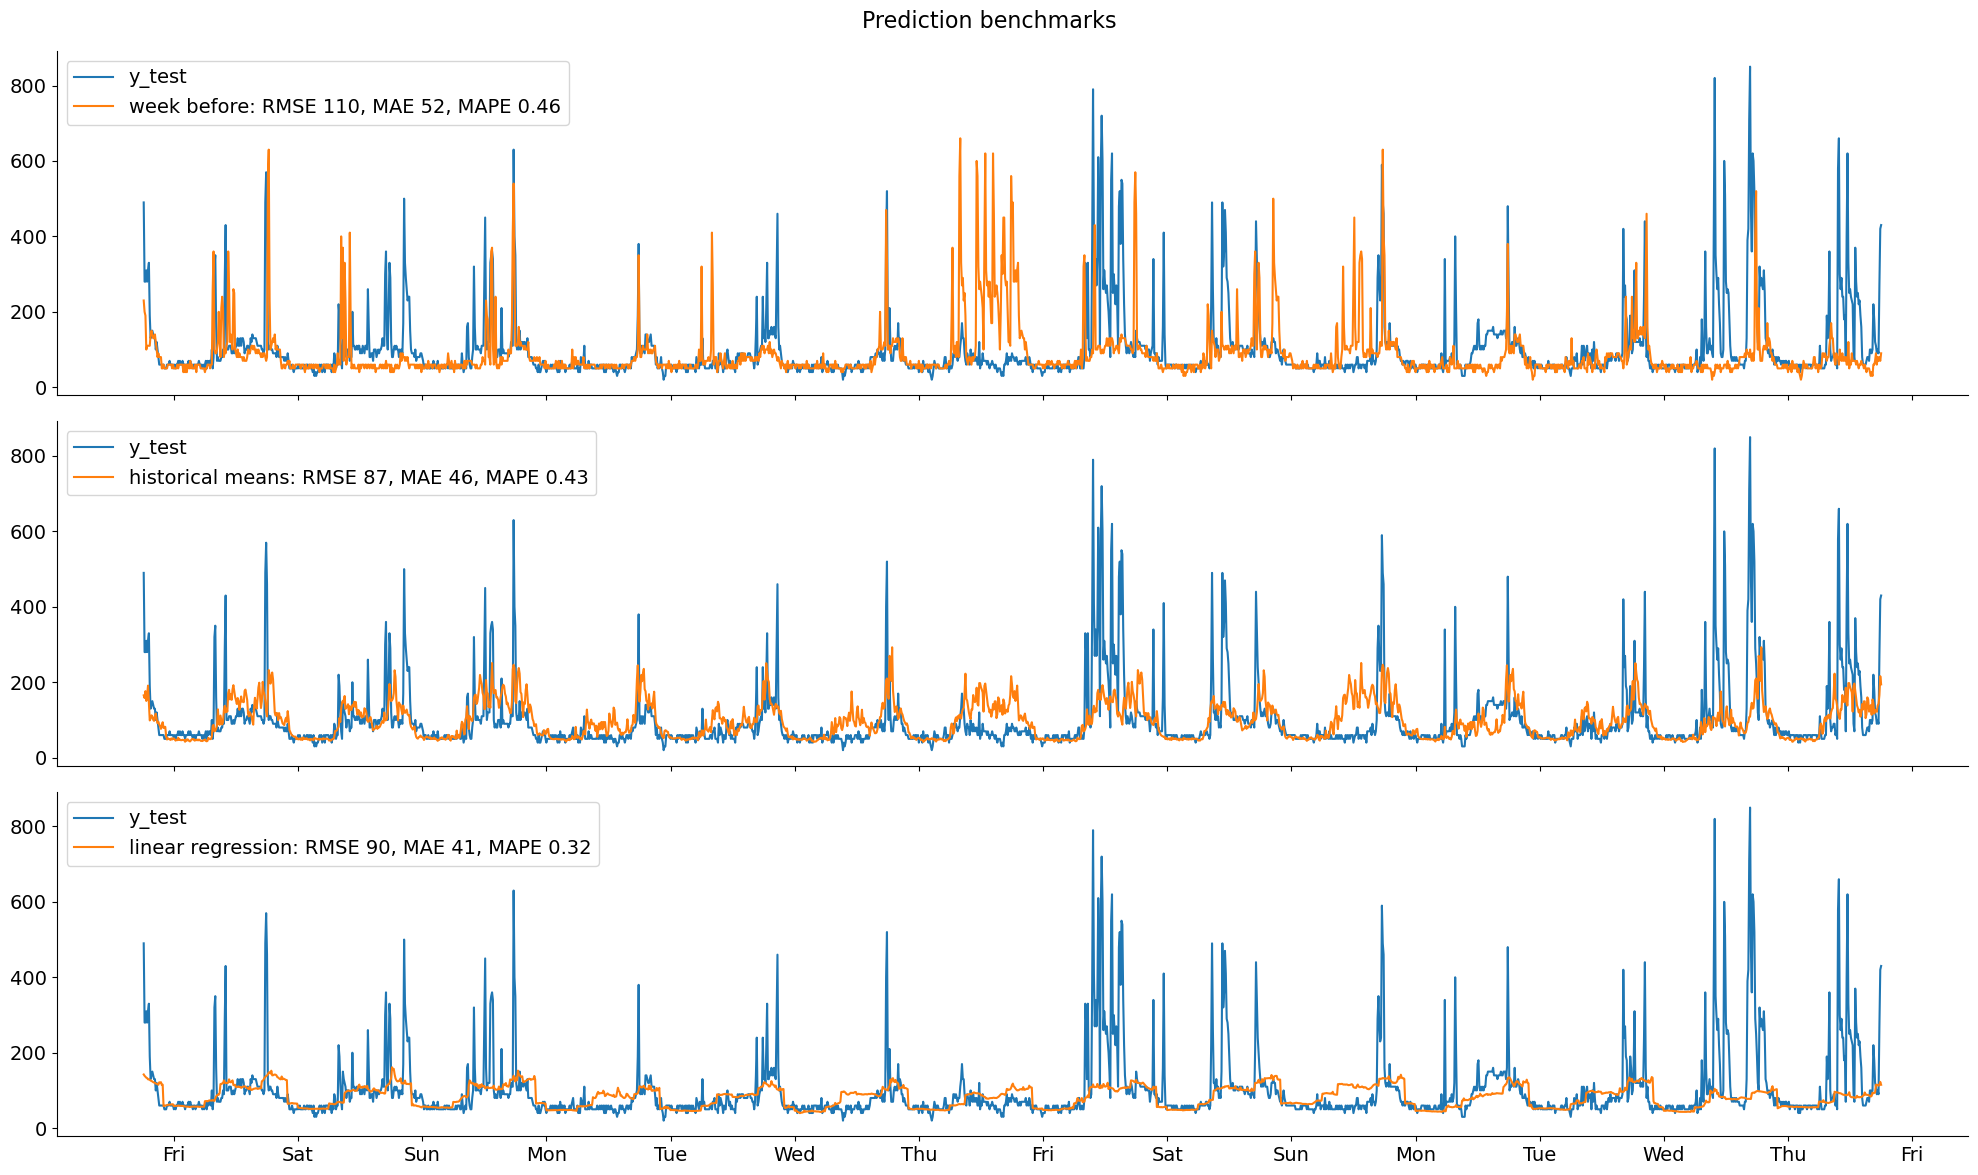

In [8]:
n_test = 2*144*7 # two weeks
prediction_benchmarks(enhanced_data, n_test)

# Experiments

In [6]:
mlflow.create_experiment(name="Initial experiments")
mlflow.set_experiment("Initial experiments")

2024/01/28 00:22:24 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/01/28 00:22:24 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1', creation_time=1706397745094, experiment_id='1', last_update_time=1706397745094, lifecycle_stage='active', name='Initial experiments', tags={}>

In [9]:
lags = [1, 2, 3, 4, 5, 6, 72, 144]
mov_windows = [2, 6, 12, 72, 144]

enhanced_data = (enhancer
                 .drop_features(["RH_6"])
                 .mark_high_values()
                 .add_lagged_features(lags=lags)
                 .add_moving_average(windows=mov_windows)
                 .add_moving_sum(windows=mov_windows)
                 .dropna()
                 .data)

X_train_lin, X_test_lin, y_train, y_test = return_train_test_data(enhanced_data,
                                                                  n_test,
                                                                  xy=True,
                                                                  ohe_drop_first=True)
X_train_tree, X_test_tree, _, _  = return_train_test_data(enhanced_data,
                                                          n_test,
                                                          xy=True)
X_train_lin.head(3)

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,minute,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_72,lag_144,moving_av_2,moving_av_6,moving_av_12,moving_av_72,moving_av_144,moving_sum_2,moving_sum_6,moving_sum_12,moving_sum_72,moving_sum_144,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_evening,time_of_day_forenoon,time_of_day_morning,time_of_day_night
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,0.0,20.066667,42.833333,19.00,42.418182,19.79,44.700000,19.26,42.560000,17.6,50.90,6.156667,18.138889,37.905556,18.6,45.790000,17.1,43.260,6.50,744.200000,75.000000,7.0,29.000000,2.30,36.465481,36.465481,17.0,0.0,2.0,12.0,0.0,0.0,0.0,40.0,40.0,40.0,50.0,40.0,30.0,50.0,60.0,50.0,45.000000,39.166667,92.361111,104.097222,100.0,270.0,470.0,6650.0,14990.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:10:00,10.0,20.000000,42.672500,19.00,42.433333,19.79,44.663333,19.20,42.560000,17.6,50.90,6.090000,18.100000,37.945455,18.6,45.808333,17.1,43.200,6.32,744.283333,76.666667,7.0,30.833333,2.43,22.628542,22.628542,17.0,10.0,2.0,12.0,0.0,0.0,0.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,60.0,60.0,48.333333,40.833333,92.500000,104.097222,120.0,290.0,490.0,6660.0,14990.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:20:00,20.0,20.000000,42.530000,18.99,42.471818,19.79,44.590000,19.20,42.626667,17.6,50.79,6.090000,18.100000,38.045000,18.6,45.900000,17.1,43.145,6.13,744.366667,78.333333,7.0,32.666667,2.57,8.756338,8.756338,17.0,20.0,2.0,12.0,0.0,0.0,1.0,60.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,135.0,75.000000,55.000000,94.861111,105.208333,270.0,450.0,660.0,6830.0,15150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [8]:
to_log_features = [feature for feature in X_train_lin.columns
                   if feature.startswith("lag")
                   or feature.startswith("moving")]
num_unique_values = X_train_lin.select_dtypes(exclude="object").nunique()
continuous_features = [col for col in num_unique_values.index if num_unique_values[col] > 3]

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
sqrt_transformer = FunctionTransformer(func=np.sqrt, inverse_func=np.square)
target_transformations = [log_transformer, sqrt_transformer, None]
anomalies_marker = [AnomaliesMarker(contamination="auto"), "passthrough"]

continuous_pipe = Pipeline([
    ("log_tr", make_column_transformer(
        (log_transformer, to_log_features),
        remainder="passthrough")),
    ("scaler", StandardScaler()),
])

preprocessor = Pipeline([
    ("col_tr", ColumnTransformer([
        ("continuous", continuous_pipe, continuous_features)
    ], remainder="passthrough")),
    ("marker", AnomaliesMarker())
])

In [50]:
X_train_lin.shape, preprocessor.fit_transform(X_train_lin).shape

((17431, 61), (17431, 62))

In [14]:
EN, Ri, ETR, HGBR, RFR, XGBR = (ElasticNet(max_iter=5000),
                                Ridge(),
                                ExtraTreesRegressor(n_jobs=-1),
                                HistGradientBoostingRegressor(),
                                RandomForestRegressor(n_jobs=-1),
                                XGBRegressor())

models = [model.set_params(random_state=SEED) for model in [EN, Ri, ETR, HGBR, RFR, XGBR]]

for_linear_preprocessor = {
    "regressor__preprocessor__col_tr__continuous": [continuous_pipe, PowerTransformer()],
    "regressor__preprocessor__marker": anomalies_marker,
    "transformer": target_transformations
}
for_tree_preprocessor = {
    "regressor__preprocessor__col_tr": ["passthrough"],
    "regressor__preprocessor__marker": anomalies_marker,
    "transformer": target_transformations
}

params = [
    {
        "regressor__model__alpha": loguniform(1e-2, 1e2),
        "regressor__model__l1_ratio": uniform(0, 1),
        **for_linear_preprocessor
    },
    {
        "regressor__model__alpha": loguniform(1e-3, 1e2),
        **for_linear_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        **for_tree_preprocessor
    },
    {
        "regressor__model__learning_rate": loguniform(1e-4, 1e0),
        "regressor__model__max_iter": randint(50, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        **for_tree_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        **for_tree_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(50, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__subsample": uniform(0.5, 0.5),
        "regressor__model__colsample_bytree": uniform(0.5, 0.5),
        "regressor__model__min_child_weight": randint(5, 50),
        "regressor__model__eta": loguniform(1e-4, 1e0),
        "regressor__model__gamma": loguniform(1e-4, 1e1),
        "regressor__model__lambda": loguniform(1e-4, 1e1),
        **for_tree_preprocessor
    }
]

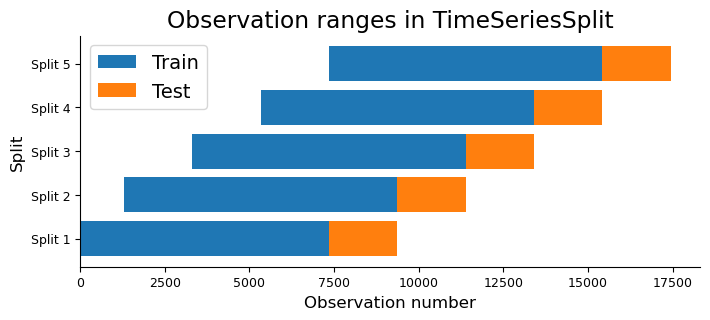

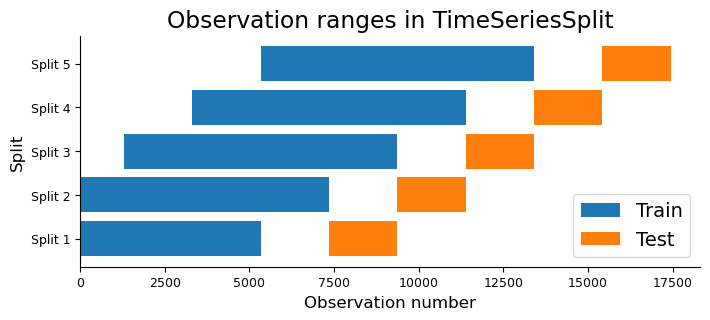

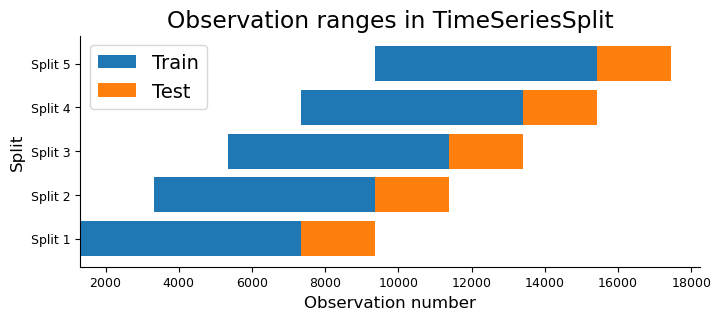

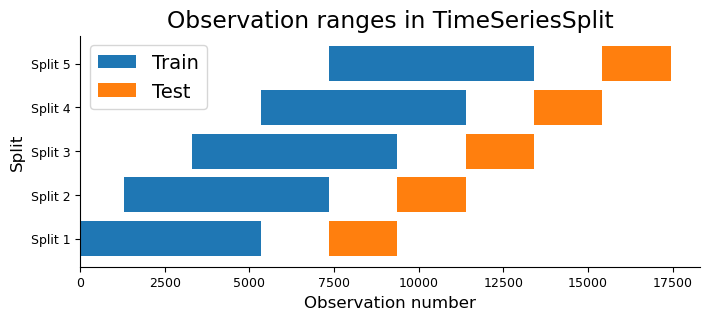

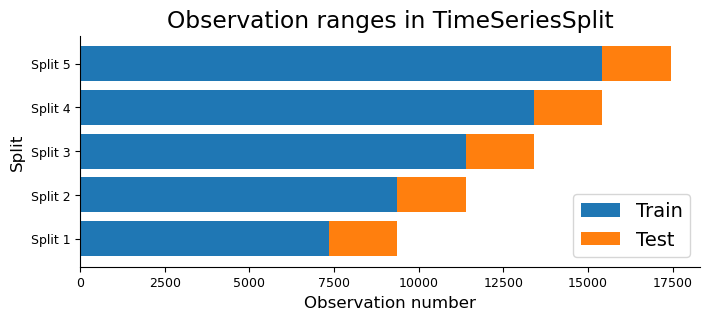

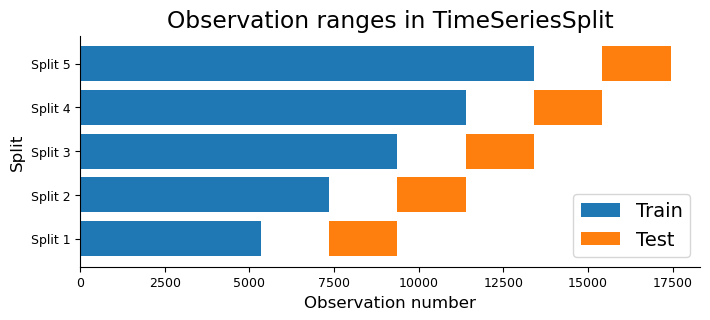

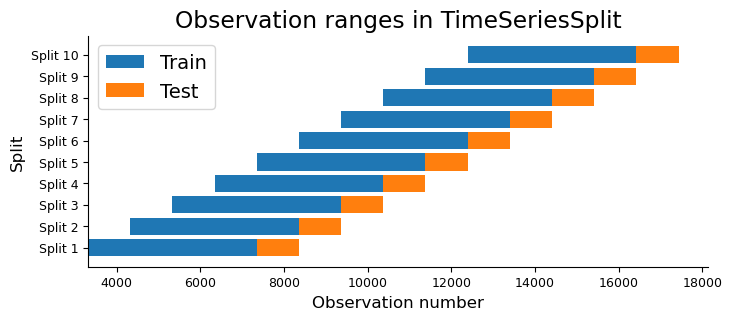

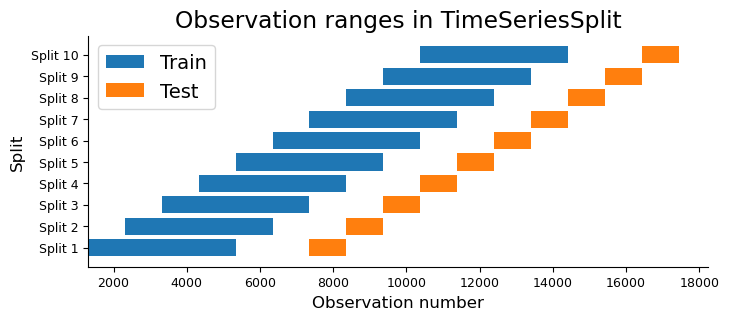

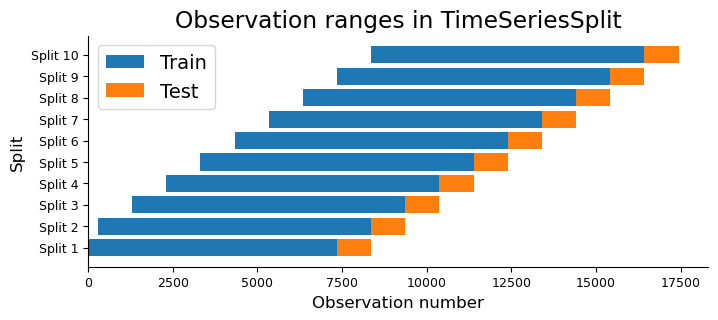

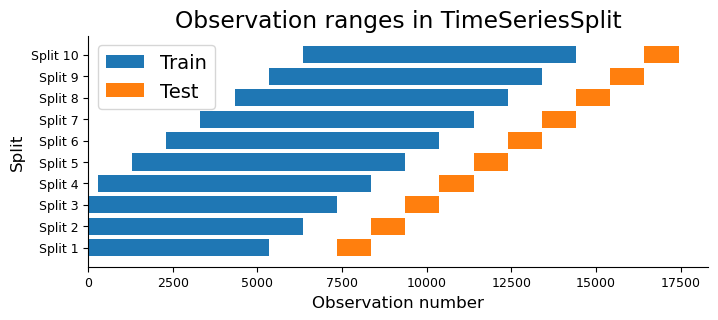

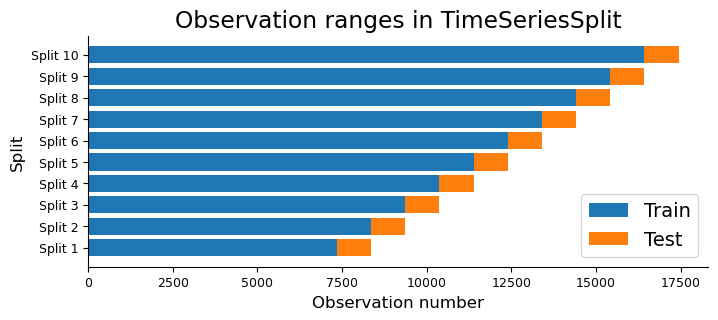

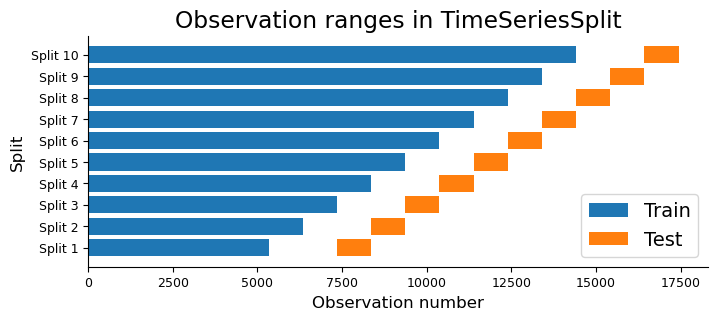

In [10]:
# n_test = 2*144*7
params_set = [
    {"n_splits": 5, "max_train_size": 4*n_test, "test_size": n_test, "gap": 0},
    {"n_splits": 5, "max_train_size": 4*n_test, "test_size": n_test, "gap": n_test},
    {"n_splits": 5, "max_train_size": 3*n_test, "test_size": n_test, "gap": 0},
    {"n_splits": 5, "max_train_size": 3*n_test, "test_size": n_test, "gap": n_test},
    {"n_splits": 5, "max_train_size": None, "test_size": n_test, "gap": 0},
    {"n_splits": 5, "max_train_size": None, "test_size": n_test, "gap": n_test},
    {"n_splits": 10, "max_train_size": 2*n_test, "test_size": int(0.5*n_test), "gap": 0},
    {"n_splits": 10, "max_train_size": 2*n_test, "test_size": int(0.5*n_test), "gap": n_test},
    {"n_splits": 10, "max_train_size": 4*n_test, "test_size": int(0.5*n_test), "gap": 0},
    {"n_splits": 10, "max_train_size": 4*n_test, "test_size": int(0.5*n_test), "gap": n_test},
    {"n_splits": 10, "max_train_size": None, "test_size": int(0.5*n_test), "gap": 0},
    {"n_splits": 10, "max_train_size": None, "test_size": int(0.5*n_test), "gap": n_test}
]

for cv_params in params_set:
    tscv = TimeSeriesSplit(**cv_params)
    time_series_split(tscv, X_train_tree)

In [15]:
all_cv_results = []

for i, cv_params in enumerate(params_set):

    to_log_table = []

    with mlflow.start_run(run_name=f"CV params {i}") as parent_run:
        
        tscv = TimeSeriesSplit(**cv_params)

        mlflow.log_params({
            "lags": lags,
            "moving_windows": mov_windows,
            "tscv_n_splits": tscv.n_splits,
            "tscv_gap": tscv.gap,
            "tscv_test_size": tscv.test_size,
            "tscv_max_test_size": tscv.max_train_size,
            "optimization": "rmse"
        })

        for model, param in zip(models, params):

            name = model.__class__.__name__

            with mlflow.start_run(run_name=f"{name}", nested=True) as child_run:

                pipeline = Pipeline([("preprocessor", preprocessor),
                                     ("model", model)])

                optimizer = RandomizedSearchCV(estimator=TransformedTargetRegressor(pipeline), 
                                               param_distributions=param, 
                                               cv=tscv,
                                               n_iter=100, 
                                               scoring={"rmse": "neg_root_mean_squared_error",
                                                        "mae": "neg_mean_absolute_error",
                                                        "mape": "neg_mean_absolute_percentage_error"},
                                               refit="rmse",
                                               n_jobs=-1,
                                               error_score="raise",
                                               return_train_score=True,
                                               random_state=SEED)

                if name in ["Ridge", "ElasticNet"]:
                    X_train, X_test = X_train_lin, X_test_lin
                else:
                    X_train, X_test = X_train_tree, X_test_tree

                optimizer.fit(X_train, y_train)

                input_example = X_test[:10]
                output_example = optimizer.best_estimator_.predict(input_example)

                input_shape = X_train.shape
                cv_results = optimizer.cv_results_
                
                results = pd.DataFrame(cv_results)
                to_drop = [col for col in results.columns if "param" in col or "time" in col]
                selected_results = results.drop(to_drop, axis=1)

                new_frame = pd.DataFrame({
                        "model": [name] * len(results),
                        "tscv_n_splits": [tscv.n_splits for _ in range(len(results))],
                        "tscv_gap": [tscv.gap for _ in range(len(results))],
                        "tscv_test_size": [tscv.test_size for _ in range(len(results))],
                        "tscv_max_test_size": [tscv.max_train_size for _ in range(len(results))],
                        "optimization": ["rmse"] * len(results)
                    })
                results = pd.concat([selected_results, new_frame], axis=1)
                to_log_table.append(results)
                all_cv_results.append(results)

                mlflow.log_params(optimizer.best_params_)
                mlflow.log_param("input_shape", input_shape)
                mlflow.set_tags({"model": name,
                                 "optimization": "rmse"})

                for metric in ["rmse", "mae", "mape"]:
                    best_index = np.argmax(cv_results[f"mean_test_{metric}"])
                    best_score = cv_results[f"mean_test_{metric}"][best_index]
                    std = cv_results[f"std_test_{metric}"].mean()

                    mlflow.log_metrics({f"best_{metric}": np.abs(best_score),
                                        f"std_{metric}": std})

                signature = mlflow.models.infer_signature(input_example,
                                                          output_example)

                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path="",
                                         signature=signature,
                                         registered_model_name=name)
                print(name, f"i = {i}", "rmse =", np.abs(optimizer.best_score_))
                
        table = pd.concat(to_log_table, axis=0)        
        mlflow.log_table(table, artifact_file="cv_results.json")

Registered model 'ElasticNet' already exists. Creating a new version of this model...
Created version '3' of model 'ElasticNet'.


ElasticNet i = 0 rmse = 92.25593190987117


Successfully registered model 'Ridge'.
Created version '1' of model 'Ridge'.


Ridge i = 0 rmse = 92.87087742776077


Successfully registered model 'ExtraTreesRegressor'.
Created version '1' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 0 rmse = 90.78005517404021


Successfully registered model 'HistGradientBoostingRegressor'.
Created version '1' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 0 rmse = 93.98538373850567


Successfully registered model 'RandomForestRegressor'.
Created version '1' of model 'RandomForestRegressor'.


RandomForestRegressor i = 0 rmse = 93.82370214693682


Successfully registered model 'XGBRegressor'.
Created version '1' of model 'XGBRegressor'.


XGBRegressor i = 0 rmse = 94.03519449764926


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

ElasticNet i = 1 rmse = 93.02905491697247


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

Ridge i = 1 rmse = 94.33690286087185


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '2' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 1 rmse = 90.62298888177149


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '2' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 1 rmse = 93.49895325459514


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '2' of model 'RandomForestRegressor'.


RandomForestRegressor i = 1 rmse = 93.99124044898512


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '2' of model 'XGBRegressor'.


XGBRegressor i = 1 rmse = 92.52044710865513


Registered model 'ElasticNet' already exists. Creating a new version of this model...
Created version '5' of model 'ElasticNet'.


ElasticNet i = 2 rmse = 92.23911341792423


Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '3' of model 'Ridge'.


Ridge i = 2 rmse = 93.14687737082605


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '3' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 2 rmse = 92.20472118717478


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '3' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 2 rmse = 92.97121861705904


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForestRegressor'.


RandomForestRegressor i = 2 rmse = 93.4501444475125


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '3' of model 'XGBRegressor'.


XGBRegressor i = 2 rmse = 93.84164274910947


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

ElasticNet i = 3 rmse = 92.69176131009807


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

Ridge i = 3 rmse = 95.49847148579713


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '4' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 3 rmse = 91.50126183510437


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '4' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 3 rmse = 93.6347579877075


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '4' of model 'RandomForestRegressor'.


RandomForestRegressor i = 3 rmse = 94.73640861049907


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '4' of model 'XGBRegressor'.


XGBRegressor i = 3 rmse = 93.42507673444594


Registered model 'ElasticNet' already exists. Creating a new version of this model...
Created version '7' of model 'ElasticNet'.


ElasticNet i = 4 rmse = 92.48568156695084


Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '5' of model 'Ridge'.


Ridge i = 4 rmse = 92.55163155505947


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '5' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 4 rmse = 89.45605124505764


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '5' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 4 rmse = 92.81633522584036


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '5' of model 'RandomForestRegressor'.


RandomForestRegressor i = 4 rmse = 91.80763784810631


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '5' of model 'XGBRegressor'.


XGBRegressor i = 4 rmse = 92.83755437450722


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

ElasticNet i = 5 rmse = 92.83036642552644


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

Ridge i = 5 rmse = 93.03670898903995


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '6' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 5 rmse = 90.49207853562237


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '6' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 5 rmse = 92.90664276796112


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '6' of model 'RandomForestRegressor'.


RandomForestRegressor i = 5 rmse = 92.42069293543283


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '6' of model 'XGBRegressor'.


XGBRegressor i = 5 rmse = 92.02976957775945


Registered model 'ElasticNet' already exists. Creating a new version of this model...
Created version '9' of model 'ElasticNet'.


ElasticNet i = 6 rmse = 92.5343795526779


Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '7' of model 'Ridge'.


Ridge i = 6 rmse = 93.26920625767573


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '7' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 6 rmse = 89.95552996866856


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '7' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 6 rmse = 92.40276026770547


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '7' of model 'RandomForestRegressor'.


RandomForestRegressor i = 6 rmse = 91.95221128689732


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '7' of model 'XGBRegressor'.


XGBRegressor i = 6 rmse = 92.62597934312278


Registered model 'ElasticNet' already exists. Creating a new version of this model...
Created version '10' of model 'ElasticNet'.


ElasticNet i = 7 rmse = 94.52678659192249


Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '8' of model 'Ridge'.


Ridge i = 7 rmse = 94.98597190713437


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '8' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 7 rmse = 92.9712841560918


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '8' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 7 rmse = 94.94185842066648


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '8' of model 'RandomForestRegressor'.


RandomForestRegressor i = 7 rmse = 94.11769755514354


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '8' of model 'XGBRegressor'.


XGBRegressor i = 7 rmse = 93.87629348371227


Registered model 'ElasticNet' already exists. Creating a new version of this model...
Created version '11' of model 'ElasticNet'.


ElasticNet i = 8 rmse = 91.97730322433021


Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '9' of model 'Ridge'.


Ridge i = 8 rmse = 92.4199980102203


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '9' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 8 rmse = 90.22287331014921


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '9' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 8 rmse = 93.32458677109858


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '9' of model 'RandomForestRegressor'.


RandomForestRegressor i = 8 rmse = 93.44012481852813


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '9' of model 'XGBRegressor'.


XGBRegressor i = 8 rmse = 93.39517174559808


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

ElasticNet i = 9 rmse = 92.66885415727401


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x =

Ridge i = 9 rmse = 93.49153610678991


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '10' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 9 rmse = 90.33784549171783


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '10' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 9 rmse = 93.97653718313563


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '10' of model 'RandomForestRegressor'.


RandomForestRegressor i = 9 rmse = 93.75416138268916


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '10' of model 'XGBRegressor'.


XGBRegressor i = 9 rmse = 93.85340864320543


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core

ElasticNet i = 10 rmse = 91.97180818651334


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core

Ridge i = 10 rmse = 91.88542585704207


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '11' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 10 rmse = 89.03191457166356


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '11' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 10 rmse = 93.02471621107237


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '11' of model 'RandomForestRegressor'.


RandomForestRegressor i = 10 rmse = 91.49753184758143


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '11' of model 'XGBRegressor'.


XGBRegressor i = 10 rmse = 91.80464249119936


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: ov

ElasticNet i = 11 rmse = 92.33697826075633


/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kasia/anaconda3/envs/energy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: ov

Ridge i = 11 rmse = 92.86982623986714


Registered model 'ExtraTreesRegressor' already exists. Creating a new version of this model...
Created version '12' of model 'ExtraTreesRegressor'.


ExtraTreesRegressor i = 11 rmse = 89.89270849814314


Registered model 'HistGradientBoostingRegressor' already exists. Creating a new version of this model...
Created version '12' of model 'HistGradientBoostingRegressor'.


HistGradientBoostingRegressor i = 11 rmse = 93.38130213293194


Registered model 'RandomForestRegressor' already exists. Creating a new version of this model...
Created version '12' of model 'RandomForestRegressor'.


RandomForestRegressor i = 11 rmse = 91.76365237877677
XGBRegressor i = 11 rmse = 92.60033598224092


Registered model 'XGBRegressor' already exists. Creating a new version of this model...
Created version '12' of model 'XGBRegressor'.


In [52]:
final_cv_results = pd.concat(all_cv_results, axis=0)
final_cv_results.to_feather("final_cv_results.feather")

In [4]:
final_cv_results = pd.read_feather("final_cv_results.feather")

In [5]:
final_cv_results

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_train_rmse,split1_train_rmse,split2_train_rmse,split3_train_rmse,split4_train_rmse,mean_train_rmse,std_train_rmse,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,split0_train_mae,split1_train_mae,split2_train_mae,split3_train_mae,split4_train_mae,mean_train_mae,std_train_mae,split0_test_mape,split1_test_mape,split2_test_mape,split3_test_mape,split4_test_mape,mean_test_mape,std_test_mape,rank_test_mape,split0_train_mape,split1_train_mape,split2_train_mape,split3_train_mape,split4_train_mape,mean_train_mape,std_train_mape,model,tscv_n_splits,tscv_gap,tscv_test_size,tscv_max_test_size,optimization,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,split5_train_rmse,split6_train_rmse,split7_train_rmse,split8_train_rmse,split9_train_rmse,split5_test_mae,split6_test_mae,split7_test_mae,split8_test_mae,split9_test_mae,split5_train_mae,split6_train_mae,split7_train_mae,split8_train_mae,split9_train_mae,split5_test_mape,split6_test_mape,split7_test_mape,split8_test_mape,split9_test_mape,split5_train_mape,split6_train_mape,split7_train_mape,split8_train_mape,split9_train_mape
0,-111.576253,-95.235794,-111.847171,-97.923046,-87.500352,-100.816523,9.531885,88,-113.436070,-107.089734,-102.051760,-103.392994,-103.752484,-105.944608,4.096431,-54.813027,-45.521599,-52.174426,-46.259501,-41.331097,-48.019930,4.847417,35,-57.126462,-53.957880,-51.605008,-50.919754,-50.323610,-52.786543,2.496153,-0.505238,-0.397266,-0.417158,-0.418060,-0.389447,-0.425434,0.041425,20,-0.566135,-0.543794,-0.500353,-0.481023,-0.461295,-0.510520,0.038979,ElasticNet,5,0,2016,8064.0,rmse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-102.074437,-86.710591,-102.948214,-89.248118,-84.022578,-93.000788,7.944051,30,-102.307163,-97.174169,-92.259871,-94.631067,-94.867823,-96.248019,3.405753,-54.405832,-47.312909,-53.523940,-49.282595,-51.087596,-51.122575,2.624753,81,-59.362392,-55.437088,-51.654718,-52.041452,-51.051939,-53.909518,3.124319,-0.590689,-0.536961,-0.530882,-0.569289,-0.614801,-0.568525,0.031770,87,-0.751033,-0.698343,-0.600615,-0.592263,-0.560105,-0.640472,0.072034,ElasticNet,5,0,2016,8064.0,rmse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-109.301809,-93.070374,-109.992699,-96.371894,-86.380612,-99.023478,9.255056,72,-111.248656,-105.132686,-100.355464,-101.765693,-102.210603,-104.142620,3.878170,-57.817191,-47.411925,-55.051219,-49.045134,-44.640206,-50.793135,4.895207,65,-60.468120,-56.866021,-54.071442,-53.538503,-52.946728,-55.578163,2.790166,-0.626295,-0.480693,-0.507465,-0.506455,-0.478312,-0.519844,0.054630,51,-0.701495,-0.662659,-0.595572,-0.574922,-0.549688,-0.616867,0.056541,ElasticNet,5,0,2016,8064.0,rmse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-100.869548,-86.197054,-104.723733,-90.810436,-82.567672,-93.033689,8.476765,32,-100.680655,-94.883860,-89.336068,-92.179912,-92.496501,-93.915399,3.813189,-49.266120,-42.969552,-51.467894,-44.403378,-37.692627,-45.159914,4.853493,24,-51.998265,-48.402039,-45.374277,-45.655664,-45.153977,-47.316844,2.619329,-0.455091,-0.434366,-0.463757,-0.436571,-0.342253,-0.426408,0.043512,33,-0.551042,-0.515601,-0.456705,-0.452320,-0.432977,-0.481729,0.044316,ElasticNet,5,0,2016,8064.0,rmse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-101.264606,-86.405740,-104.488370,-90.309139,-82.334193,-92.960409,8.541229,27,-100.974652,-95.278253,-89.877908,-92.711529,-93.002878,-94.369044,3.721419,-49.275684,-42.321508,-50.990103,-43.409119,-37.700342,-44.739351,4.833495,17,-52.026103

## Best model so far:

In [10]:
conn = sqlite3.connect("mlruns.db")

artifact_uri = pd.read_sql(
    """
    SELECT artifact_uri
    FROM runs
    JOIN metrics ON metrics.run_uuid = runs.run_uuid
    WHERE key = 'best_rmse'
    ORDER BY value ASC
    LIMIT 1
    """,
    conn
).iloc[0, 0]

conn.close()

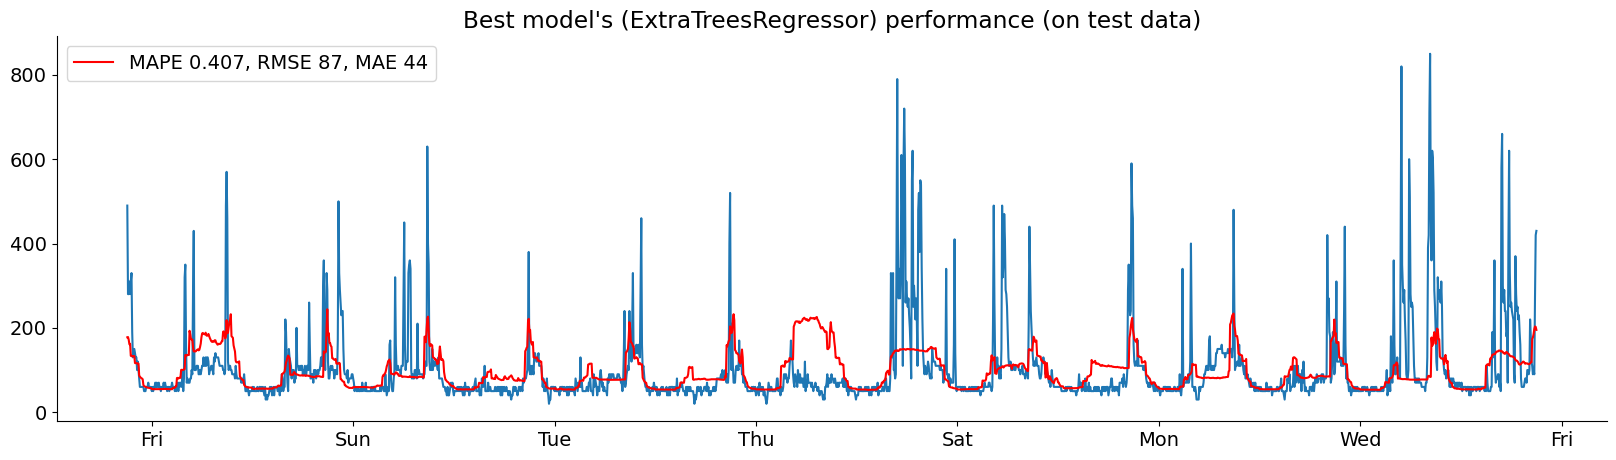

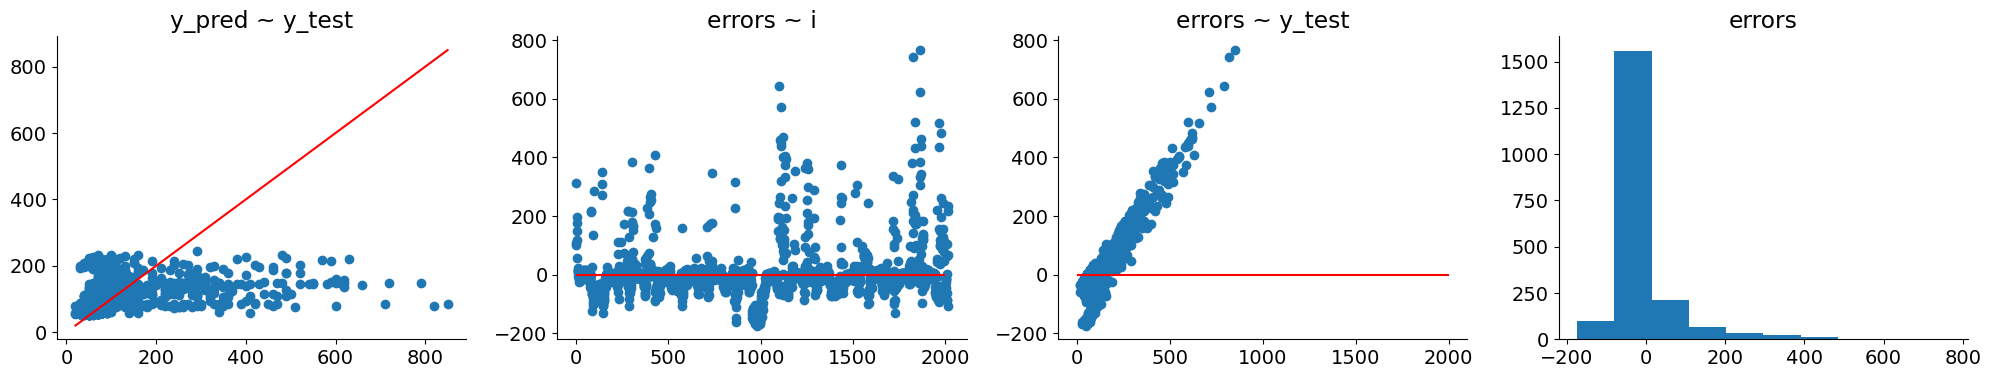

In [11]:
loaded_model = mlflow.sklearn.load_model(artifact_uri)

evaluate_model(X_test_tree, y_test, loaded_model)

In [43]:
# loaded_model.get_params()

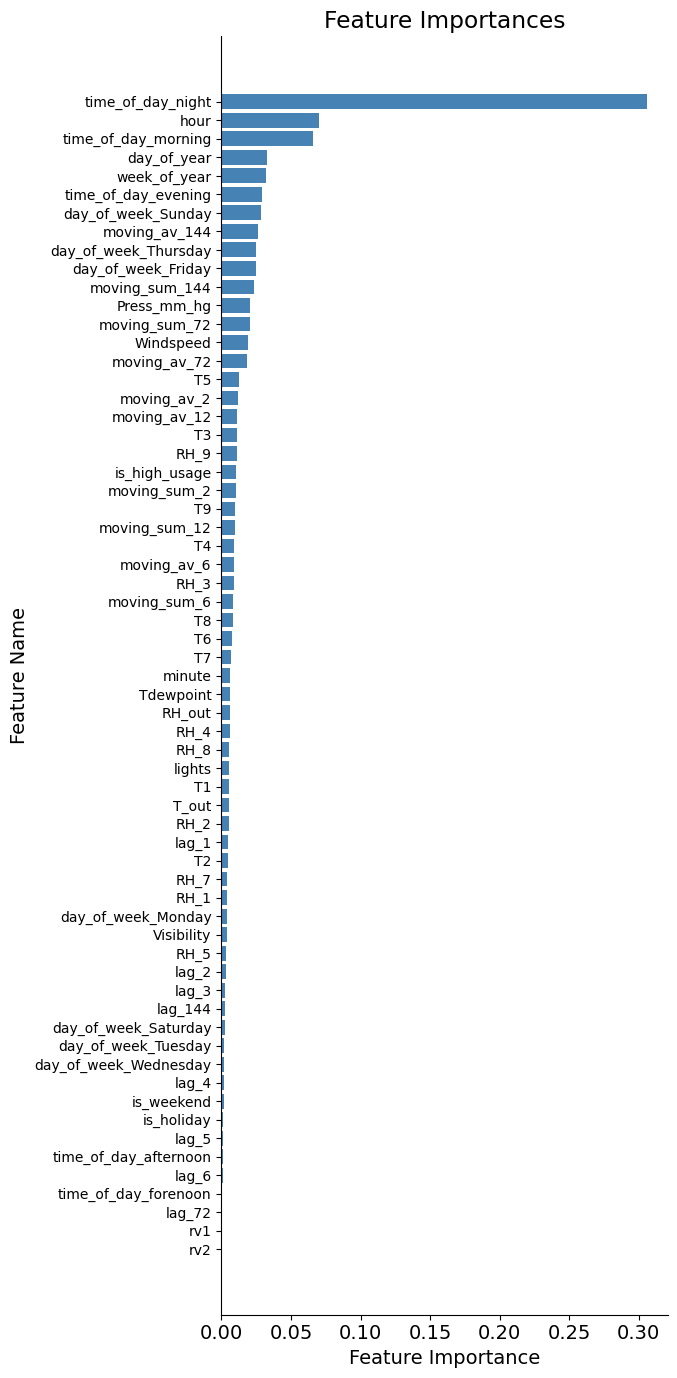

In [42]:
# np.set_printoptions(suppress=True, precision=8)
importances = loaded_model.regressor_.named_steps["model"].feature_importances_
cols = list(X_train_tree.columns)
# cols.append("anomalies")
feature_importances(importances, cols)